In [48]:
import numpy as np
import math
np.warnings.filterwarnings('ignore')
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def debugMatrix(name, M):
    print(name, ":\n", type(M), "shape: ", M.shape, "\n", M)

def getRotationMatrixX(ax, rad=False):
    if not rad:
        ax = np.radians(ax)
    sx = np.sin(ax)
    cx = np.cos(ax)
    return np.array(((1, 0, 0), (0, cx, -sx), (0, sx, cx)))

def getRotationMatrixY(ay, rad=False):
    if not rad:
        ay = math.radians(ay)
    sy = np.sin(ay)
    cy = np.cos(ay)
    return np.array(((cy, 0, sy), (0, 1, 0), (-sy, 0, cy)))

def getRotationMatrixZ(az, rad=False):
    if not rad:
        az = math.radians(az)
    sz = np.sin(az)
    cz = np.cos(az)
    return np.array(((cz, -sz, 0), (sz, cz, 0), (0, 0, 1)))

def getRotationMatrix(ax,ay,az,rad=False,order="XYZ",debug=False):
    X = getRotationMatrixX(ax, rad)
    Y = getRotationMatrixY(ay, rad)
    Z = getRotationMatrixZ(az, rad)

    if debug:
        debugMatrix("Rotation X", X)
        debugMatrix("Rotation Y", Y)
        debugMatrix("Rotation Z", Z)

    if order == "XYZ":
        return Z @ Y @ X
    elif order == "ZYX":
        return X @ Y @ Z
    elif order == "YXZ":
        return Z @ X @ Y
    elif order == "YZX":
        return X @ Z @ Y
    elif order == "XZY":
        return Y @ Z @ X
    elif order == "ZXY":
        return Y @ X @ Z

# Return camera to world and world to camera
def getHomoTransforms(rotation_matrix, translation_matrix, debug=False):
    # The only rotation is about x
    debugMatrix("R", rotation_matrix)
    debugMatrix("T", translation_matrix)
    H_c_w = np.block([[rotation_matrix, translation_matrix], [0,0,0,1]]) 
    # Get transformation from world to camera.
    H_w_c = np.linalg.inv(H_c_w)
    if debug:
        debugMatrix("H_w_c", H_w_c)
        debugMatrix("H_c_w", H_c_w)
    return H_c_w, H_w_c

# Return Matrix K
# f: focal_length
# sx: sensor size x
# sy: sensor size y
# center: pixel location [x,y] of optical center of image
def getIntrinsicCamMatrix(f, center=[0,0]):
    return np.array([[f, 0, center[0]], [0, f, center[1]], [0, 0, 1]])

# Returns Mext
def getExtrinsicCamMatrix(H_w_c):
    Mext = H_w_c[0:3, :]
    return Mext


In [49]:
############################################################
# Utility function for 3D plots.
def setAxesEqual(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's    
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.    
    Input      ax: a matplotlib axis, e.g., as output from plt.gca().    '''
    x_limits = ax.get_xlim3d()    
    y_limits = ax.get_ylim3d()    
    z_limits = ax.get_zlim3d()    
    x_range = abs(x_limits[1] - x_limits[0])    
    x_middle = np.mean(x_limits)    
    y_range = abs(y_limits[1] - y_limits[0])    
    y_middle = np.mean(y_limits)    
    z_range = abs(z_limits[1] - z_limits[0])    
    z_middle = np.mean(z_limits)
    # The plot bounding box is a sphere in the sense of the infinity    
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])    
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])    
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])    
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
############################################################

# Draw three 3D line segments, representing xyz unit axes, onto the axis figure ax.
# H is the 4x4 transformation matrix representing the pose of the coordinate frame.
def draw_coordinate_axes(ax, H, label):
    p = H[0:3, 3]      
    # Origin of the coordinate frame
    ux = H @ np.array([1,0,0,1])   
    # Tip of the x axis
    uy = H @ np.array([0,1,0,1])   
    # Tip of the y axis
    uz = H @ np.array([0,0,1,1])   
    # Tip of the z axis
    ax.plot(xs=[p[0], ux[0]], ys=[p[1], ux[1]], zs=[p[2], ux[2]], c='r')   
    # x axis
    ax.plot(xs=[p[0], uy[0]], ys=[p[1], uy[1]], zs=[p[2], uy[2]], c='g')   
    # y axis
    ax.plot(xs=[p[0], uz[0]], ys=[p[1], uz[1]], zs=[p[2], uz[2]], c='b')   
    # z axis
    ax.text(p[0], p[1], p[2], label)   # Also draw the label of the coordinate frame

Rotation X :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
Rotation Y :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
Rotation Z :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
Rotation X :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1.         0.         0.       ]
 [ 0.        -0.5        0.8660254]
 [ 0.        -0.8660254 -0.5      ]]
Rotation Y :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
Rotation Z :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Rotation X :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
Rotation Y :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
Rotation Z :
 <class 'numpy.ndarray'> shape:  (3, 3) 
 [[ 1. -0.  

<IPython.core.display.Javascript object>


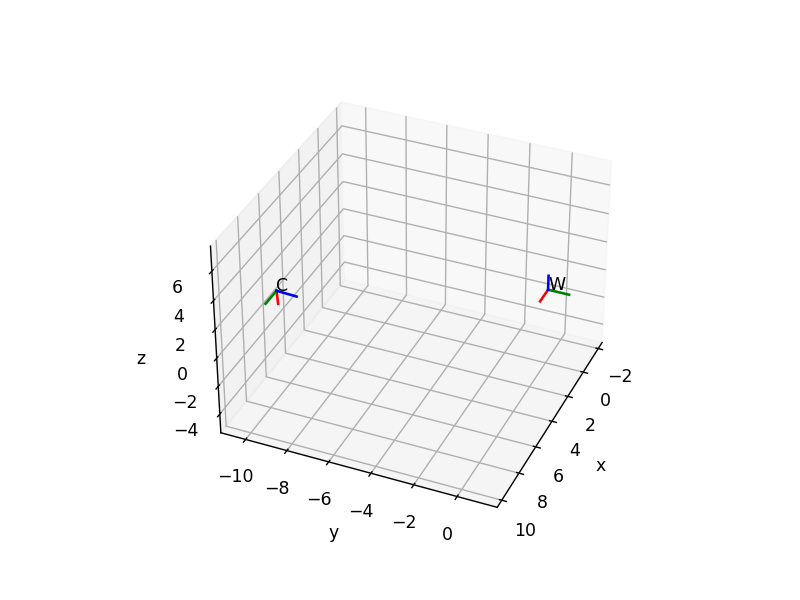

In [47]:
#Camera Angles
ax1 = 0
ay1 = 0
az1 = 30
ax2 = -120
ay2 = 0
az2 = 0
ax3 = 0
ay3 = 0
az3 = 0

# Camera Parameters
height = 480
width = 640
focal = 600
cx = width/2.0
cy = height/2.0

# camera position to mount translation matrix
t_c_m = np.array([[0,-1.5,0]]).T

# mount position to vehicle translation matrix
t_m_v = np.array([[0,-3,0]]).T

# Translation Matrix
t_v_w = np.array([[6,-8,1]]).T

# World Points
points = np.array([[-1, -1, 0, 1],
                   [1, -1, 0, 1],
                   [1, 1, 0, 1],
                   [-1, 1, 0, 1],
                   [0,0,-3,1]])


try:
    #  Give the 3x3 rotation matrix corresponding to the rotations above.
    R_v_w = getRotationMatrix(ax1,ay1,az1,rad=False,order="ZYX",debug=True)
    R_m_v = getRotationMatrix(ax2,ay2,az2,rad=False,order="XYZ",debug=True)
    
    # 0 degree Rotation matrix for camera to mount
    R_c_m = getRotationMatrix(ax3,ay3,az3,rad=False,order="XYZ",debug=True)


    # Compute the homogeneous transformation matrix that represents the pose
    # of the camera with respect to the world
    H_c_m, H_m_c = getHomoTransforms(R_c_m, t_c_m, debug=True)
    H_m_v, H_v_m = getHomoTransforms(R_m_v, t_m_v, debug=True)
    H_v_w, H_w_v = getHomoTransforms(R_v_w, t_v_w, debug=True)
    
    # Homogeneous Camera to World
    H_c_w = H_v_w @ H_m_v @ H_c_m
    # Homogenous World to Camera
    H_w_c = np.linalg.inv(H_c_w)
    
    # Write the intrinsic camera calibration matrix K.
    K = getIntrinsicCamMatrix(focal, center=[cx,cy])
    debugMatrix("K", K)

    # Find Mext
    Mext = H_w_c[0:3, :]
    
    # Find new points on image
    new_points = []
    for point in points:
        p = K @ Mext @ point
        p = p / p[2]
        new_points.append(p)

    # Create a blank (zeros) image, and project the 7 points to the image.
    # Write white dots into the image at those points. 
    image = np.zeros((width,height, 3))
    print(new_points)
    for point in new_points:
        image[np.abs(int(point[1]))][np.abs(int(point[0]))] = (0,0,255)

    # Using OpenCV's “line” function, draw lines between the points on the image. 
    # Namely draw a line from point 0 to point 1, another line from point 1 
    # to point 2, and so forth. 
    for i in range(len(new_points) -1):
        image = cv2.line(image,(int(new_points[i][0]),int(new_points[i][1])), (int(new_points[i+1][0]), int(new_points[i+1][1])),(255,0,0),thickness=1)

    image = cv2.line(image,(int(new_points[len(new_points)-1][0]),int(new_points[len(new_points)-1][1])), (int(new_points[0][0]), int(new_points[0][1])),(255,0,0),thickness=1)
    image = cv2.line(image,(int(new_points[len(new_points)-1][0]),int(new_points[len(new_points)-1][1])), (int(new_points[1][0]), int(new_points[1][1])),(255,0,0),thickness=1)
    image = cv2.line(image,(int(new_points[len(new_points)-1][0]),int(new_points[len(new_points)-1][1])), (int(new_points[2][0]), int(new_points[2][1])),(255,0,0),thickness=1)
    image = cv2.line(image,(int(new_points[len(new_points)-1][0]),int(new_points[len(new_points)-1][1])), (int(new_points[3][0]), int(new_points[3][1])),(255,0,0),thickness=1)
    image = cv2.line(image,(int(new_points[0][0]),int(new_points[0][1])), (int(new_points[3][0]), int(new_points[3][1])),(255,0,0),thickness=1)
    # Save image
    cv2.imwrite("Pyramid_Camera_View.jpg", image)
    cv2.imshow("Pyramid Camera View", image)
    cv2.waitKey(0)
finally:
    cv2.destroyAllWindows()
    # Draw scene in 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    draw_coordinate_axes(ax, np.eye(4), 'W')
    draw_coordinate_axes(ax, H_c_w, 'C')
    setAxesEqual(ax)
    plt.savefig("Wire_Frame.png")
    plt.show()  # This shows the plot, and pauses until you close the figure